## Imports

In [18]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from copy import deepcopy

from math import pi, cos, sin, sqrt, tan, acos
import numpy as np
from numpy import array, zeros, arange
from numpy import concatenate as np_concat
from numpy import real
from numpy.linalg import eig as eigenvalues
import matplotlib.pyplot as plt

from calculate_system import EquationCalculator
from progress_bar import ProgressBar
from create_fig import *
from function_root_finder import roots



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [6]:
M = 2.0
c1 = 1000.0
c0 = 1.0 * c1

beta = 0.1

r = 0.04
I = 2.0

b = 0.5  # engine
d = 0.01

# 3 DOF additions

m = M * 0.02

L = 1.2
gamma = pi / 6

beta1 = beta * 1.0
beta2 = beta * 0.5

c2 = c1 * 0.4
c3 = c1 * 0.4

# dimensionless max engine rotation velocity. 1 = resonance
engine_om_max = 2.5

In [7]:
def recalculate_supplementary_parameters(print_parameters=True, new_eps=0.1):
    global om_l, k, om, Lcos, k0, engine_om_max, a, OM_max, K_L, q, eps, K_, h1, \
           h, r_, mu, k2, k3, r_eps, h2, ro, Aw, Aw2, r_eps2, k2_, k3_, kw, kw_, ro_
        
    om_l = sqrt(c1 / M)
    k = c0 / c1
    om = sqrt(1 + k)

    Lcos = L * cos(gamma)
    k0 = k

    #

    engine_om_max_ = om * engine_om_max
    a = engine_om_max_ * (b - d) * om_l

    OM_max = a / b
    K_L = a / OM_max
    q = OM_max / om_l

    if print_parameters:
        print("om_l   = ", om_l)
        print("k      = ", k)
        print("om     = ", om)
        print("K_L    = ", K_L)
        print("OM_max = ", OM_max)
        print("q      = ", q)
        print("")

    eps = new_eps

    K_ = K_L / om_l / I / eps
    h1 = d / om_l / I / eps
    h = beta1 / om_l / M / eps
    r_ = r / eps

    mu = m / M / eps
    k2 = c2 / c1 / eps
    k3 = c3 / c1 / eps
    r_eps = r / Lcos / eps
    h2 = beta2 / M / om_l / eps**2

    ro = r_eps * M / I * Lcos**2

    if print_parameters:
        print("eps    = ", eps)
        print("K_L    = ", K_L)
        print("h      = ", h)
        print("h1     = ", h1)
        print("r_     = ", r_)

    Aw = (2.0 - 2.0 * cos(gamma)) ** 0.5 / eps
    Aw2 = Aw ** 2
    r_eps2 = r_eps / eps

    k2_ = k2 / cos(gamma)
    k3_ = k3 / cos(gamma)
    kw = (k2 + k3) * (1 - 1 / cos(gamma))  # kw + (k2+k3) / cos(gamma) * 1.5 * Aw2 * eps #
    kw_ = 2 * (k2 + k3) * (1 / cos(gamma) - 1)
    ro_ = ro * eps

    print("recalculate, engine om max = %f", engine_om_max_)

    if print_parameters:
        print("Aw     = ", Aw)

In [8]:
recalculate_supplementary_parameters(print_parameters=True, new_eps=0.1)

om_l   =  22.360679774997898
k      =  1.0
om     =  1.4142135623730951
K_L    =  0.5
OM_max =  77.4758026741253
q      =  3.464823227814083

eps    =  0.1
K_L    =  0.5
h      =  0.022360679774997897
h1     =  0.0022360679774997894
r_     =  0.39999999999999997
recalculate, engine om max = %f 3.5355339059327378
Aw     =  5.176380902050413


## Equations

2 Dof system equation

In [5]:
def initial_2_DOF(t, v):
    """
    F[0] = x
    F[1] = x'
    F[2] = fi
    F[3] = fi'
    """
    F = zeros(4)
    F[0] = v[1]
    F[1] = (-c1*(v[0]-r*sin(v[2])) - c0*v[0] - beta*v[1]) / M
    F[2] = v[3]
    F[3] = (K_L * (OM_max - v[3]) - d*v[3] + c1*r * (v[0] - r*sin(v[2])) * cos(v[2])) / I
    return F

2 Dof system with inclusion of small parameter

In [6]:
def initial_2_DOF_with_eps(t, v):
    """
    v[0] = x
    v[1] = x'
    v[2] = fi
    v[3] = fi'
    """
    F = zeros(4)
    F[0] = v[1]
    F[1] = -(om**2)*v[0] + eps * (r_*sin(v[2]) - h*v[1])
    F[2] = v[3]
    F[3] = eps * (K_ * (q - v[3]) - h1*v[3] + r_ * v[0] * cos(v[2]) * M/I) - (eps**2) * (r_**2 * 0.5 * sin(2.0 * v[2]) * M/I)
    return F

## 2 Dof system check

In [7]:
initial_eq = EquationCalculator(initial_2_DOF, [0, 0, 0, 0], method='rk5a', ignore_cache=True)
initial_eq.step_size /= om_l
initial_eq.caclulate()


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


In [8]:
initial_eps = EquationCalculator(initial_2_DOF_with_eps, [0, 0, 0, 0], method='rk5a', ignore_cache=True, time_scale=om_l)
initial_eps.caclulate()


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


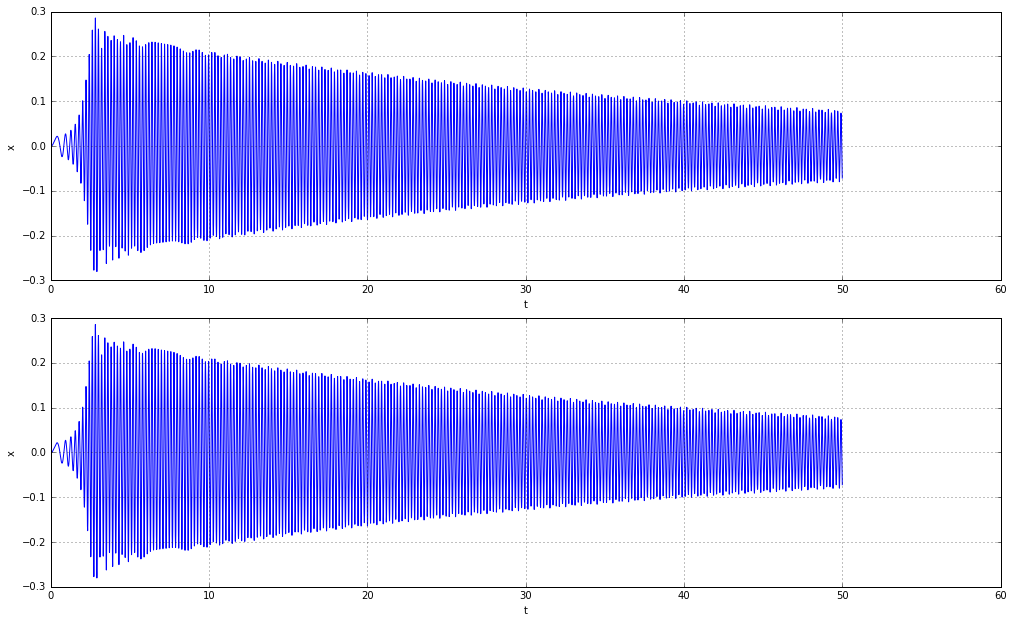

In [9]:
%matplotlib inline

fig = create_fig()
plots = add_subplots(fig, 2)

initial_eq.plot(plots[0], 't', '.t', 'x', '.v0', 'b-')
initial_eps.plot(plots[1], 't', '.t', 'x', '.v0', 'b-')

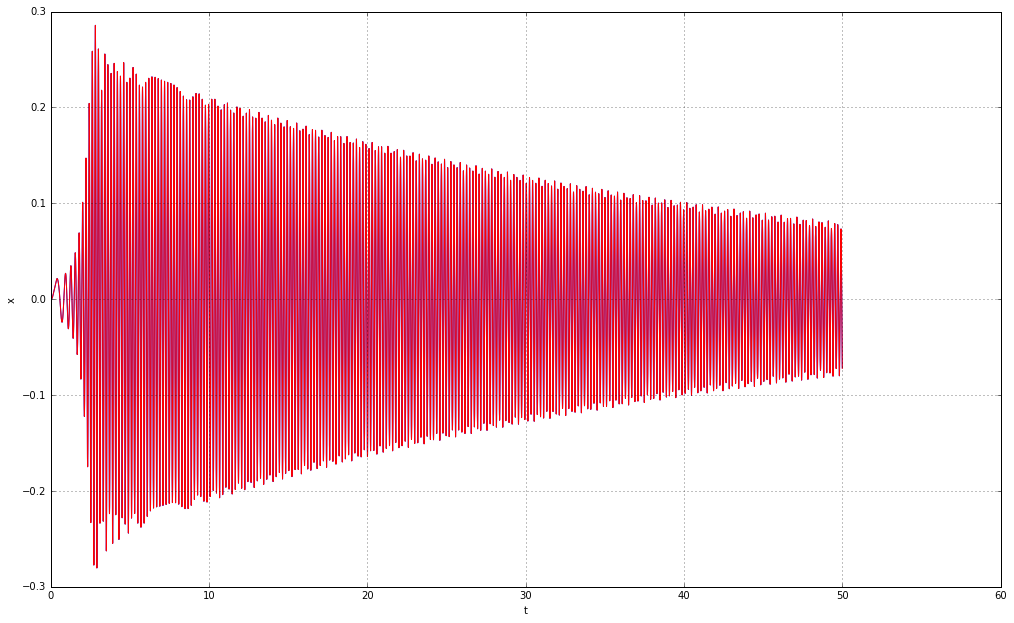

In [10]:
%matplotlib inline

fig = create_fig()
plots = add_subplots(fig, 1)

initial_eq.plot(plots[0], 't', '.t', 'x', '.v0', 'b-')
initial_eps.plot(plots[0], 't', '.t', 'x', '.v0', 'r-')

## 3DOF sysem stability and verification

In [5]:
# stability parameters
p0 = K_*q / (K_ + h1)
# p0 = om * 2.5
a0 = p0 * h2/mu/2.0
D = k2_/8.0/mu * Aw * r_eps / (p0**2 - om**2)
D12 = (D / a0)**2

delta = 0
k_a = 3 * (k2_+k3_) / 4.0 / mu

In [6]:
# satbility function
def f(n):
    return ((k_a*D12)**2 * (n**3)
            + delta*k_a*D12 * (n**2)
            + (0.25*delta**2 + a0**2) * n
            - a0**2)

In [7]:
STABLE = 0
UNSTABLE = 1
UNKNOWN = 2

unknown_barier = 0.0001
t0 = -1000000.0

def stability(a0, b0):
    K05 = 0.5 * (K_ + h1)
    m00 = 0
    m01 = 0
    m02 = -K05 * p0
    m10 = -p0 * h2/mu/2.0
    m11 = -D * sin(b0)
    m12 = a0 * (K05 - h2/mu/2.0)
    m20 = delta/2.0/a0 + 3*k_a*a0
    m21 = -D/a0 * cos(b0)
    m22 = p0 * t0 * K05
    matrix = array([[m00, m01, m02], [m10, m11, m12], [m20, m21, m22]])

    w, v = eigenvalues(matrix)
#     print(w)
    if all([abs(real(l)) < unknown_barier for l in w]):
#         print("UNKNOWN")
        return UNKNOWN
    elif all([real(l) < 0 for l in w]):
#         print("STABLE")
        return STABLE
    else:
#         print("UNSTABLE")
        return UNSTABLE

In [240]:
#preparation

xs, ys = [[], [], []], [[], [], []]
max_y = 0
deltas = np_concat(
    (arange(-10.0, 30, 0.1), arange(0.0, 1.0, 0.005), arange(0.36, 0.4, 0.0001))
#     (arange(-10.0, 30, 0.1), arange(0.0, 1.0, 0.005), arange(0.36, 0.4, 0.0001))
)

# calculate stability

pb = ProgressBar("Stability points", 0, len(deltas) - 1)
pb_counter = 0
for i in deltas:
    pb.setValue(pb_counter)
    pb_counter += 1

    delta = -i
    ns = roots(f, 0.0, 1.0, eps=1e-3)

    for n in ns:
        b = acos(n ** 0.5)
        a = (n ** 0.5) * (D / a0)
        st = stability(a, b)

        ys[st].append(a)
        xs[st].append(i)
        
        if max_y < a:
            max_y = a    



[= Stability points ==============================]
[=================================================]


In [241]:
# calculate field (optional)
field_x = arange(-1.0, 3.0, 0.025)
field_y = arange(0.01, max_y + 0.01, 0.01)
pb = ProgressBar("Stability field", 0, len(field_x) - 1)
pb_counter = 0

xs2 = deepcopy(xs)
ys2 = deepcopy(ys)

for i in field_x:
    pb.setValue(pb_counter)
    pb_counter += 1
    for j in field_y:
        if j > max_y:
            xs2[UNKNOWN].append(i)
            ys2[UNKNOWN].append(j)
            continue

        delta = -i
        a = j
        b = acos(a / D * a0)
        st = stability(a, b)
        xs2[st].append(i)
        ys2[st].append(j)


[= Stability field ===============================]
[=================================================]


<IPython.core.display.Javascript object>


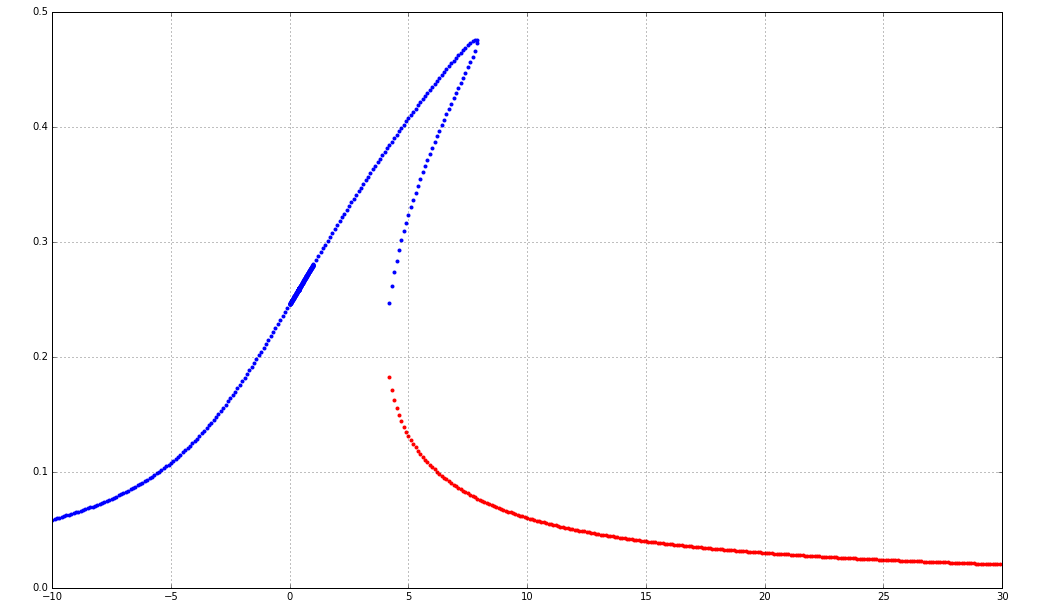

In [242]:
%matplotlib notebook

fig = create_fig()
plt.grid(b=True)

plt.plot(xs[STABLE], ys[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs[UNSTABLE], ys[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(xs[UNKNOWN], ys[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)

<IPython.core.display.Javascript object>


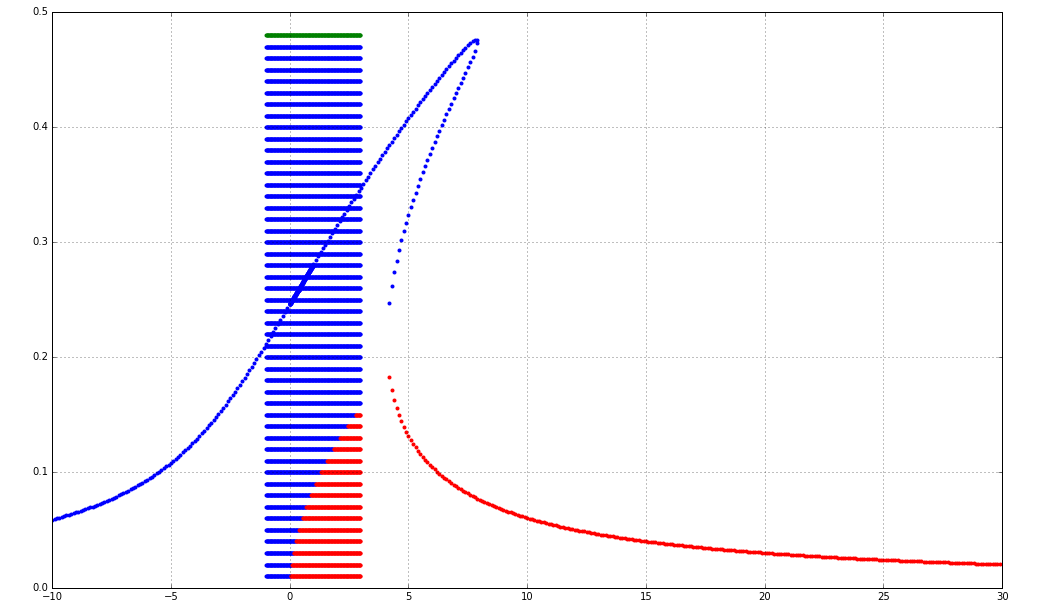

In [243]:
%matplotlib notebook

fig = create_fig()
plt.grid(b=True)

plt.plot(xs2[STABLE], ys2[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs2[UNSTABLE], ys2[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(xs2[UNKNOWN], ys2[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)

In [51]:
print(a0)
print(D)
print("Stable")
for i in range(len(xs[STABLE])):
    _d = xs[STABLE][i]
    _a = ys[STABLE][i]
    _b = acos(_a * a0 / D) 
    print ("delta: %f,\ta: %f,\tb: %f" % (_d, _a, _b))

0.06329722440696511
0.030148003480231535
Stable
delta: -1.000000,	a: 0.059114,	b: 1.446362
delta: -0.990000,	a: 0.059681,	b: 1.445162
delta: -0.980000,	a: 0.060259,	b: 1.443940
delta: -0.970000,	a: 0.060847,	b: 1.442695
delta: -0.960000,	a: 0.061446,	b: 1.441426
delta: -0.950000,	a: 0.062057,	b: 1.440133
delta: -0.940000,	a: 0.062679,	b: 1.438815
delta: -0.930000,	a: 0.063314,	b: 1.437472
delta: -0.920000,	a: 0.063960,	b: 1.436102
delta: -0.910000,	a: 0.064620,	b: 1.434705
delta: -0.900000,	a: 0.065292,	b: 1.433280
delta: -0.890000,	a: 0.065977,	b: 1.431827
delta: -0.880000,	a: 0.066677,	b: 1.430344
delta: -0.870000,	a: 0.067390,	b: 1.428831
delta: -0.860000,	a: 0.068118,	b: 1.427288
delta: -0.850000,	a: 0.068860,	b: 1.425712
delta: -0.840000,	a: 0.069619,	b: 1.424103
delta: -0.830000,	a: 0.070392,	b: 1.422461
delta: -0.820000,	a: 0.071182,	b: 1.420784
delta: -0.810000,	a: 0.071989,	b: 1.419071
delta: -0.800000,	a: 0.072813,	b: 1.417321
delta: -0.790000,	a: 0.073654,	b: 1.415533
delta:

delta: 0.510000,	a: 0.410712,	b: 0.530981
delta: 0.515000,	a: 0.333909,	b: 0.793916
delta: 0.515000,	a: 0.412118,	b: 0.525124
delta: 0.520000,	a: 0.337094,	b: 0.784494
delta: 0.520000,	a: 0.413519,	b: 0.519227
delta: 0.525000,	a: 0.340222,	b: 0.775155
delta: 0.525000,	a: 0.414915,	b: 0.513290
delta: 0.530000,	a: 0.343296,	b: 0.765889
delta: 0.530000,	a: 0.416306,	b: 0.507310
delta: 0.535000,	a: 0.346319,	b: 0.756687
delta: 0.535000,	a: 0.417692,	b: 0.501286
delta: 0.540000,	a: 0.349295,	b: 0.747541
delta: 0.540000,	a: 0.419074,	b: 0.495217
delta: 0.545000,	a: 0.352227,	b: 0.738444
delta: 0.545000,	a: 0.420450,	b: 0.489101
delta: 0.550000,	a: 0.355116,	b: 0.729387
delta: 0.550000,	a: 0.421822,	b: 0.482936
delta: 0.555000,	a: 0.357965,	b: 0.720365
delta: 0.555000,	a: 0.423188,	b: 0.476721
delta: 0.560000,	a: 0.360777,	b: 0.711370
delta: 0.560000,	a: 0.424550,	b: 0.470453
delta: 0.565000,	a: 0.363552,	b: 0.702397
delta: 0.565000,	a: 0.425906,	b: 0.464132
delta: 0.570000,	a: 0.366294,	b: 0

In [52]:
print("Unstable")
for i in range(len(xs[UNSTABLE])):
    _d = xs[UNSTABLE][i]
    _a = ys[UNSTABLE][i]
    _b = acos(_a * a0 / D) 
    print ("delta: %f,\ta: %f,\tb: %f" % (_d, _a, _b))

Unstable
delta: 0.420000,	a: 0.183302,	b: 1.175748
delta: 0.430000,	a: 0.171386,	b: 1.202707
delta: 0.440000,	a: 0.162702,	b: 1.222176
delta: 0.450000,	a: 0.155674,	b: 1.237833
delta: 0.460000,	a: 0.149699,	b: 1.251077
delta: 0.470000,	a: 0.144469,	b: 1.262621
delta: 0.480000,	a: 0.139803,	b: 1.272885
delta: 0.490000,	a: 0.135582,	b: 1.282144
delta: 0.500000,	a: 0.131723,	b: 1.290584
delta: 0.510000,	a: 0.128167,	b: 1.298345
delta: 0.520000,	a: 0.124868,	b: 1.305529
delta: 0.530000,	a: 0.121792,	b: 1.312217
delta: 0.540000,	a: 0.118909,	b: 1.318472
delta: 0.550000,	a: 0.116198,	b: 1.324345
delta: 0.560000,	a: 0.113640,	b: 1.329880
delta: 0.570000,	a: 0.111219,	b: 1.335111
delta: 0.580000,	a: 0.108922,	b: 1.340068
delta: 0.590000,	a: 0.106737,	b: 1.344777
delta: 0.600000,	a: 0.104655,	b: 1.349260
delta: 0.610000,	a: 0.102668,	b: 1.353535
delta: 0.620000,	a: 0.100767,	b: 1.357620
delta: 0.630000,	a: 0.098947,	b: 1.361529
delta: 0.640000,	a: 0.097200,	b: 1.365275
delta: 0.650000,	a: 0.095

<IPython.core.display.Javascript object>


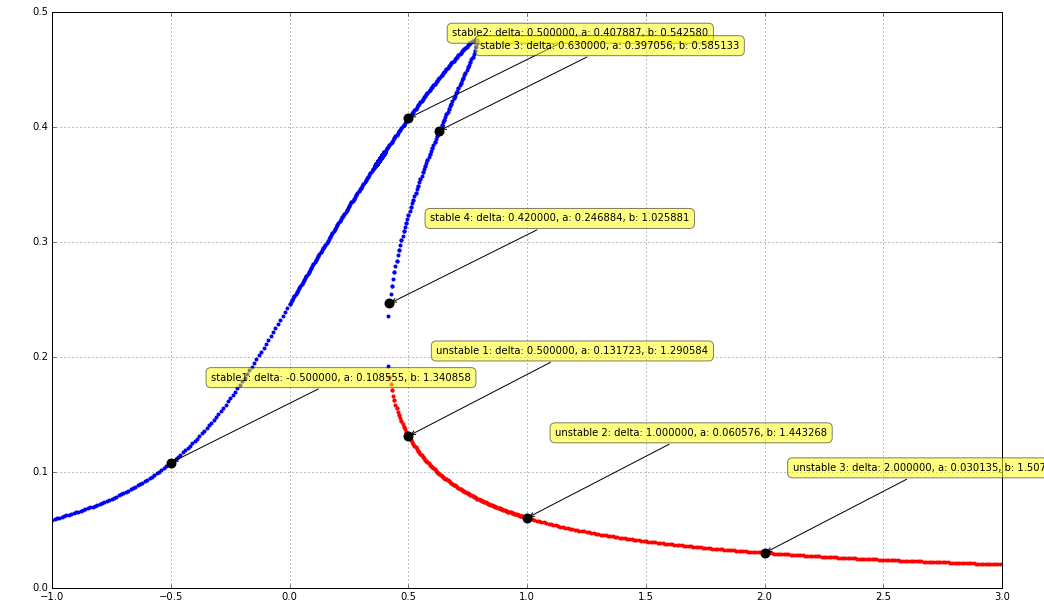

In [53]:
# display selected points

fig = create_fig()
plt.grid(b=True)

plt.plot(xs[STABLE], ys[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs[UNSTABLE], ys[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(xs[UNKNOWN], ys[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)

labels = [
 ["stable1: delta: -0.500000, a: 0.108555, b: 1.340858" , -0.5, 0.108555],
 ["stable2: delta: 0.500000, a: 0.407887, b: 0.542580", 0.5, 0.407887],
 ["stable 3: delta: 0.630000, a: 0.397056, b: 0.585133", 0.63,  0.397056],
 ["stable 4: delta: 0.420000, a: 0.246884, b: 1.025881", 0.42, 0.246884],
 ["unstable 1: delta: 0.500000, a: 0.131723, b: 1.290584", 0.5,  0.131723],
 ["unstable 2: delta: 1.000000, a: 0.060576, b: 1.443268", 1.0,  0.060576],
 ["unstable 3: delta: 2.000000, a: 0.030135, b: 1.507484", 2.0,  0.030135]
]

for label, x, y in labels:
    plt.annotate(
        label,
        xy=(x, y), xytext=(300, 80),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.plot(x, y, "ko", markeredgewidth=0.0, markersize=10)

In [21]:
# a b equation
def ab(t, v):
    """
    F[0] = a
    f[1] = b
    """
    a = v[0]
    b = v[1]
    F = zeros(2)
    F[0] = -a * h2/2.0/mu + D/p0 * cos(b)
    F[1] = 1/p0 * (0.5 * delta - k_a*a**2 - D/a * sin(b))
    return F
    

In [54]:
def check_ab_stability(_del, _a, _b):
    global delta
    delta = _del

    ab_check1 = EquationCalculator(ab, [_a, _b], method='rk5a', ignore_cache=True, t_end=1000.0)
    ab_check1.caclulate()

    fig = create_fig()
    plots = add_subplots(fig, 2)
    ab_check1.plot(plots[0], "t", ".t", "a", ".v0", "b-")
    ab_check1.plot(plots[1], "t", ".t", "b", ".v1", "b-")

<IPython.core.display.Javascript object>


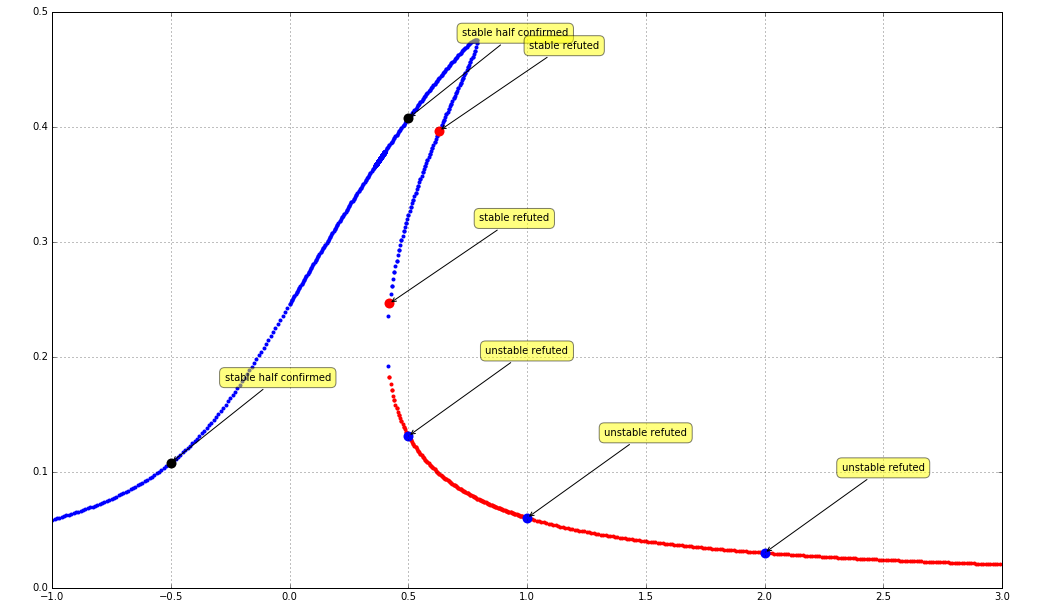

In [61]:
# display selected points

fig = create_fig()
plt.grid(b=True)

plt.plot(xs[STABLE], ys[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs[UNSTABLE], ys[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(xs[UNKNOWN], ys[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)

labels = [
 ["stable half confirmed" , -0.5, 0.108555, "ko"],
 ["stable half confirmed", 0.5, 0.407887, "ko"],
 ["stable refuted", 0.63,  0.397056, "ro"],
 ["stable refuted", 0.42, 0.246884, "ro"],
 ["unstable refuted", 0.5,  0.131723, "bo"],
 ["unstable refuted", 1.0,  0.060576, "bo"],
 ["unstable refuted", 2.0,  0.030135, "bo"]
]

for label, x, y, marker in labels:
    plt.annotate(
        label,
        xy=(x, y), xytext=(160, 80),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.plot(x, y, marker, markeredgewidth=0.0, markersize=10)


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


<IPython.core.display.Javascript object>


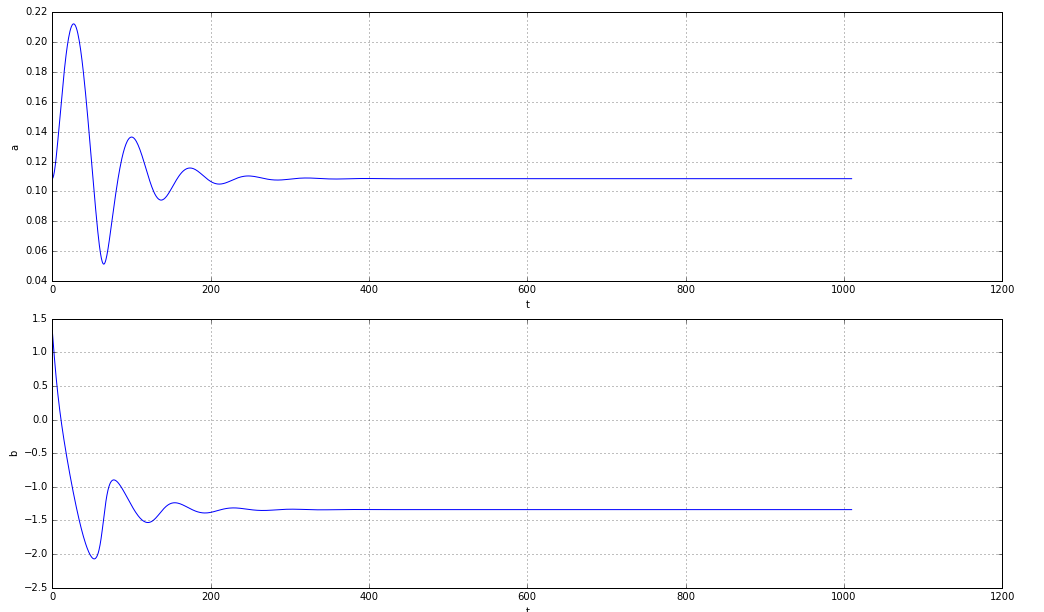

In [55]:
%matplotlib notebook

# stable 1
# delta: -0.500000,	a: 0.108555,	b: 1.340858

check_ab_stability(-0.5, 0.108555, 1.340858)


[= Runge Kutta 5 Adaptive ========================]
[================================================]


<IPython.core.display.Javascript object>


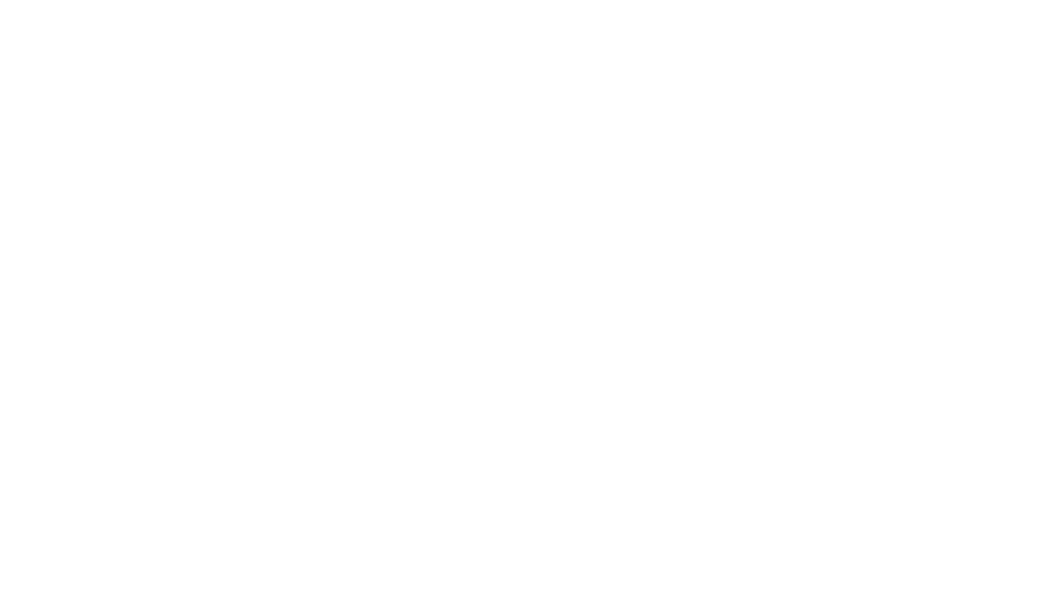

In [24]:
# stable 1 with negative b
# delta: -0.500000,	a: 0.108555,	b: 1.340858

check_ab_stability(-0.5, 0.108555, -1.340858)


[= Runge Kutta 5 Adaptive ========================]
[================================================]


<IPython.core.display.Javascript object>


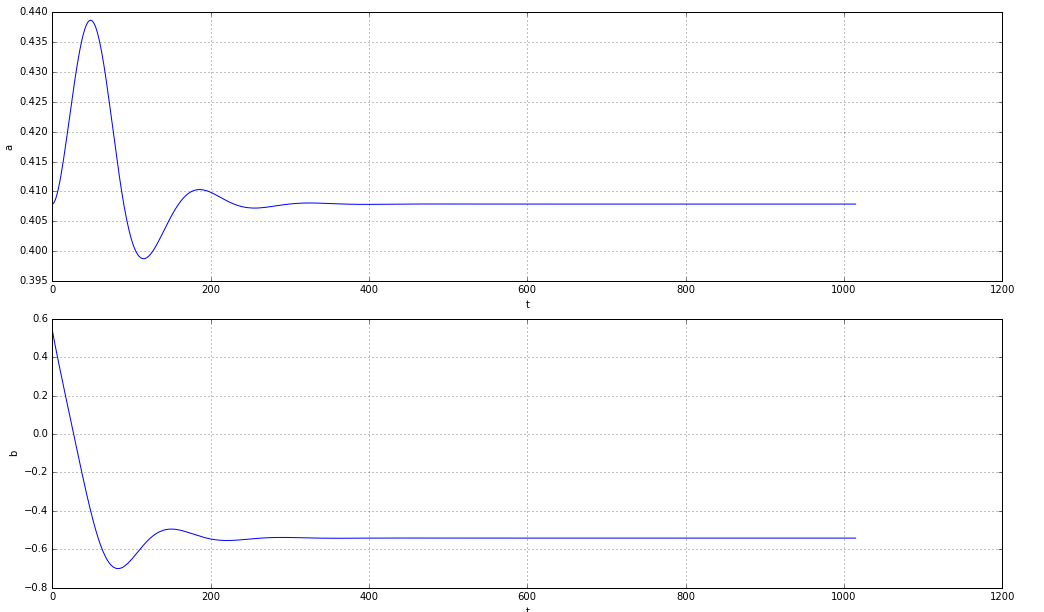

In [56]:
# stable 2

# delta: 0.500000,	a: 0.407887,	b: 0.542580

check_ab_stability(0.5, 0.407887, 0.542580)


[= Runge Kutta 5 Adaptive ========================]
[===============================================]


<IPython.core.display.Javascript object>


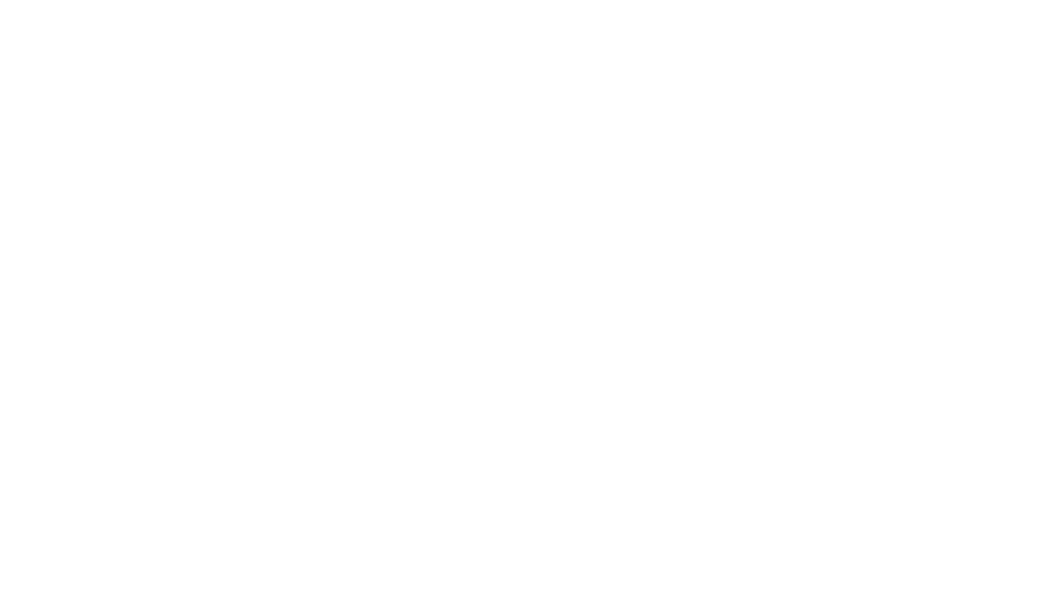

In [26]:
# stable 2 with negative b

# delta: 0.500000,	a: 0.407887,	b: 0.542580

check_ab_stability(0.5, 0.407887, -0.542580)


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


<IPython.core.display.Javascript object>


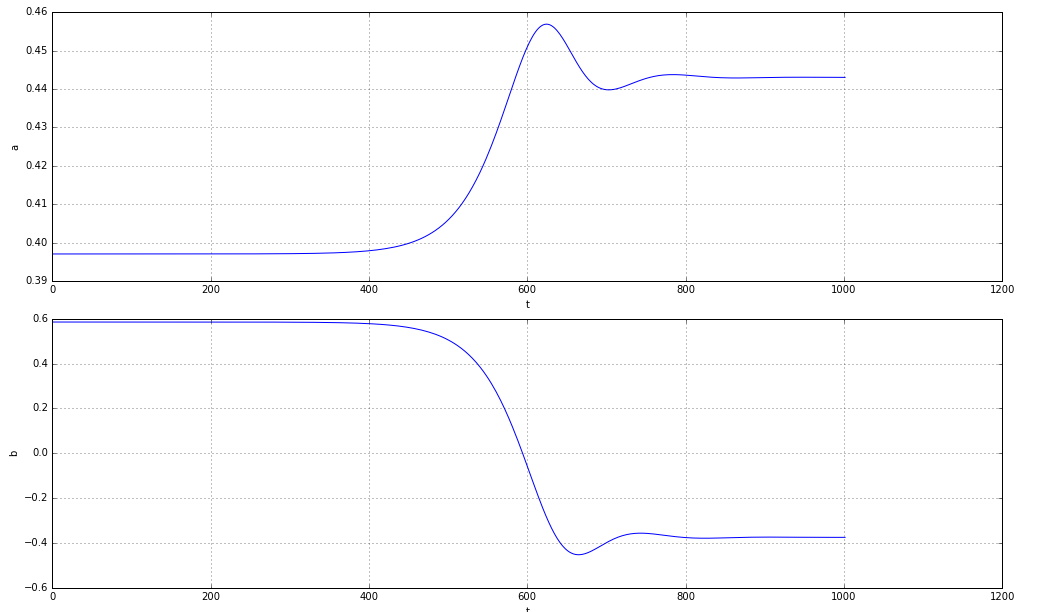

In [57]:
# stable 3: delta: 0.630000, a: 0.397056, b: 0.585133
check_ab_stability(0.630000, 0.397056, 0.585133)


[= Runge Kutta 5 Adaptive ========================]
[===================================================

<IPython.core.display.Javascript object>


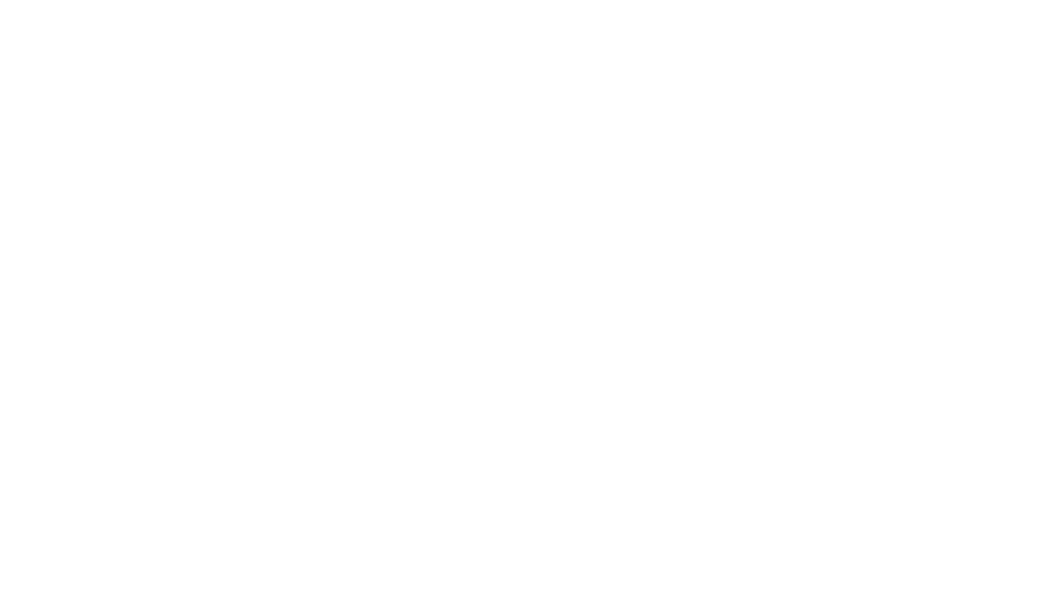

In [28]:
# stable 3: delta: 0.630000, a: 0.397056, b: 0.585133 (with disturbance)
check_ab_stability(0.630000, 0.397056 + 0.005, 0.585133 + 0.005)


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


<IPython.core.display.Javascript object>


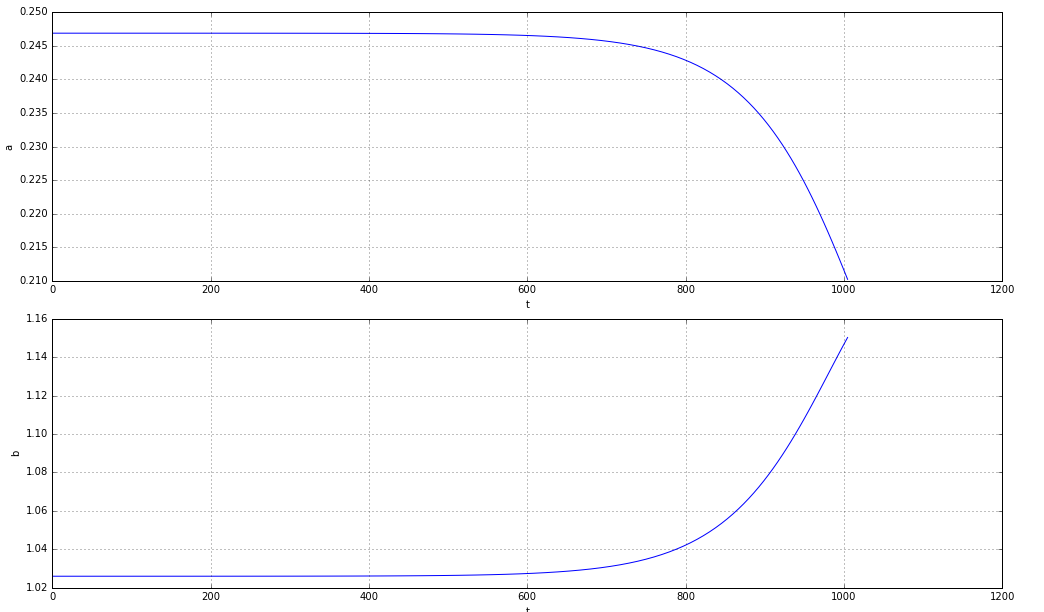

In [58]:
# stable 4: delta: 0.420000, a: 0.246884, b: 1.025881
check_ab_stability(0.420000, 0.246884, 1.025881)


[= Runge Kutta 5 Adaptive ========================]
[===================================================

<IPython.core.display.Javascript object>


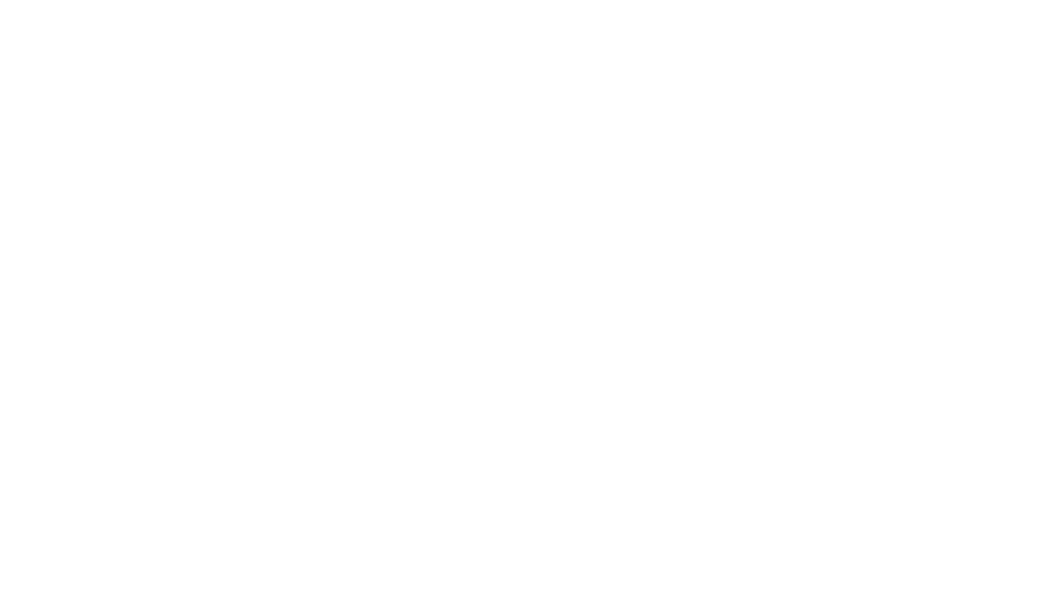

In [30]:
# stable 4: delta: 0.420000, a: 0.246884, b: 1.025881 (with disturbance)
check_ab_stability(0.420000, 0.246884 - 0.001, 1.025881 + 0.001)


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


<IPython.core.display.Javascript object>


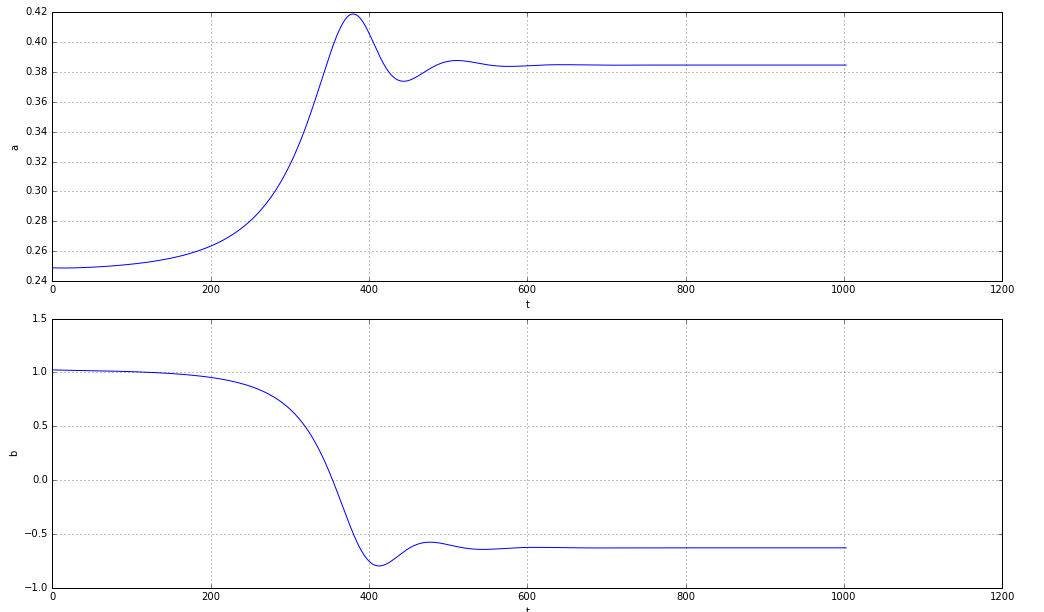

In [59]:
# stable 4: delta: 0.420000, a: 0.246884, b: 1.025881 (with disturbance 2)
check_ab_stability(0.420000, 0.246884 + 0.002, 1.025881 - 0.002)


[= Runge Kutta 5 Adaptive ========================]
[===============================================]


<IPython.core.display.Javascript object>


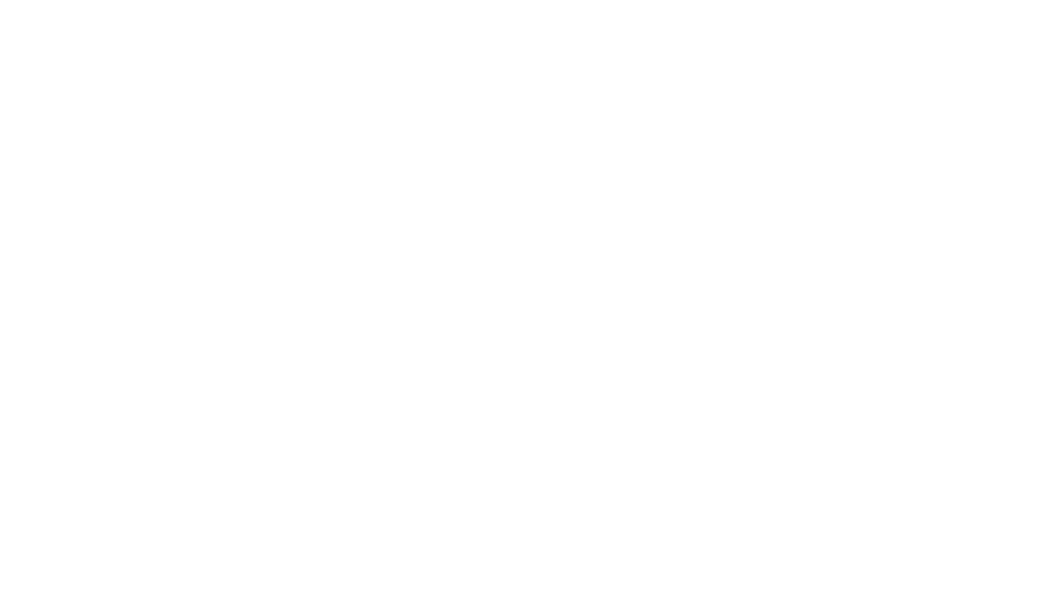

In [32]:
# unstable 1: delta: 0.500000, a: 0.131723, b: 1.290584
check_ab_stability(0.500000, 0.131723, 1.290584)


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


<IPython.core.display.Javascript object>


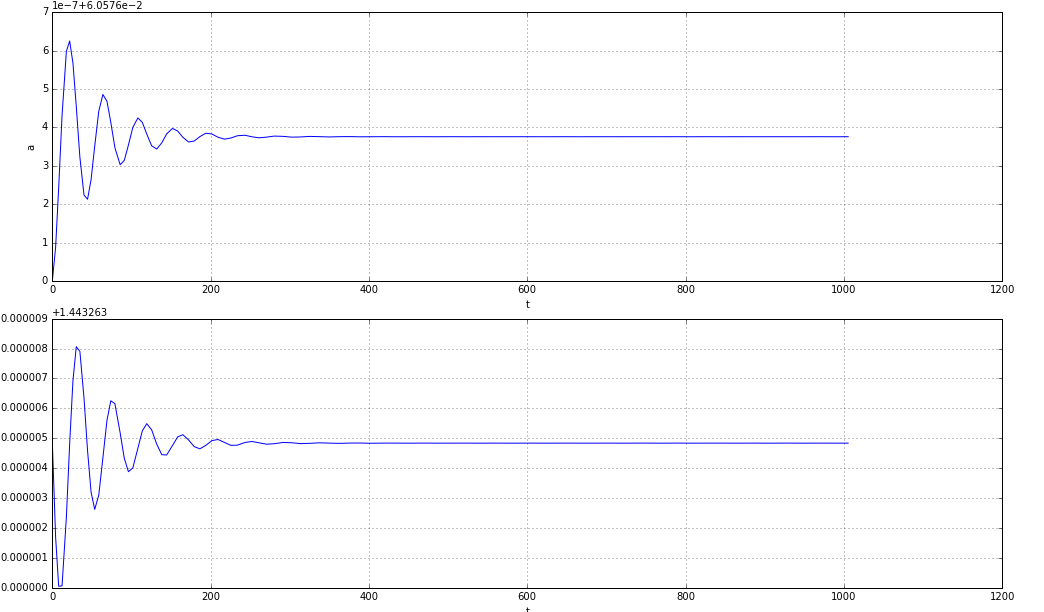

In [60]:
# unstable 2: delta: 1.000000, a: 0.060576, b: 1.443268
check_ab_stability(1.000000, 0.060576, 1.443268)


[= Runge Kutta 5 Adaptive ========================]
[=================================================]


<IPython.core.display.Javascript object>


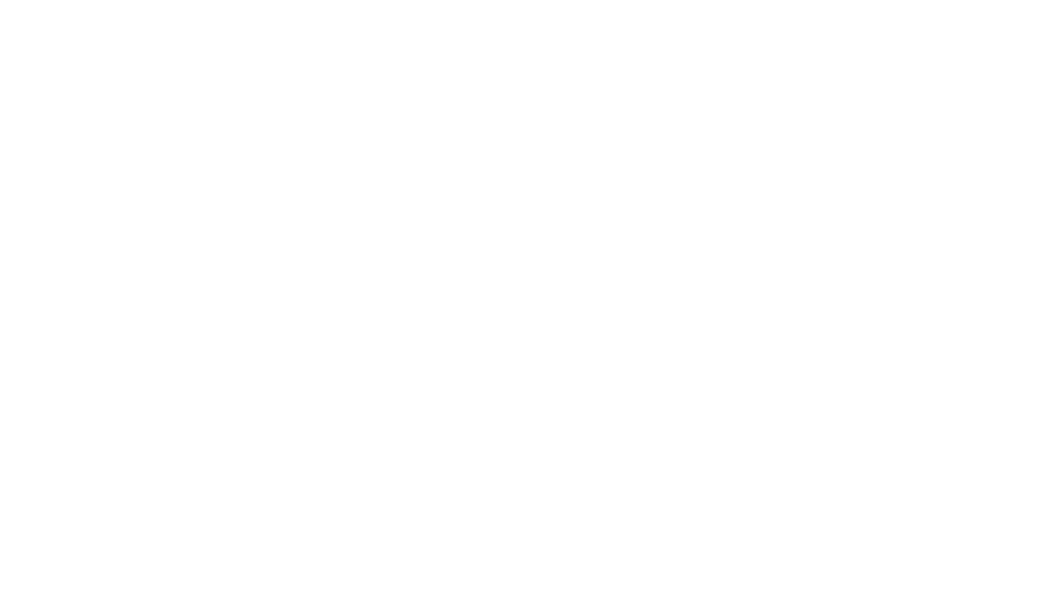

In [34]:
# unstable 3: delta: 2.000000, a: 0.030135, b: 1.507484
check_ab_stability(2.000000, 0.030135, 1.507484)

# Stability try 3

In [9]:
def recalculate_stab_params():
    global p0, a0, D, D12, delta, k_a
    p0 = K_*q / (K_ + h1)
    a0 = p0 * h2/mu/2.0
    D = k2_/8.0/mu * Aw * r_eps / (p0**2 - om**2)
    D12 = (D / a0)**2
    
    om_w2 = (kw_ / mu)

    delta = (om_w2 - p0**2) / eps
    k_a = 3 * (k2_+k3_) / 4.0 / mu
    

recalculate_stab_params()

# for i in arange()
print("K_", K_)
print("q", q)
print("h1", h1)
print("p0", p0)
print("mu = ", mu)
print("kw_", kw_)
print("om_w = ", (kw_ / mu) ** 0.5)
print("delta = ", ((kw_ / mu) - p0**2) / eps)
print("D =", D)

om_w = (kw_ / mu) ** 0.5
qis = arange(om_w - 1.6, om_w + 0.8, 0.004)

for q_i in qis:
    q = q_i
    recalculate_stab_params()
    print(delta)

K_ 0.11180339887498948
q 3.464823227814083
h1 0.0022360679774997894
p0 3.396885517464787
mu =  0.19999999999999998
kw_ 2.4752086140680234
om_w =  3.5179600723061255
delta =  8.37211851578104
D = 0.6029600696046309
88.4031562036
88.255523749
88.1075837203
87.9593361177
87.8107809411
87.6619181904
87.5127478657
87.3632699671
87.2134844944
87.0633914477
86.912990827
86.7622826322
86.6112668635
86.4599435208
86.308312604
86.1563741133
86.0041280485
85.8515744097
85.6987131969
85.5455444101
85.3920680493
85.2382841145
85.0841926057
84.9297935228
84.775086866
84.6200726351
84.4647508303
84.3091214514
84.1531844985
83.9969399716
83.8403878707
83.6835281958
83.5263609469
83.3688861239
83.211103727
83.053013756
82.894616211
82.7359110921
82.5768983991
82.4175781321
82.2579502911
82.0980148761
81.937771887
81.777221324
81.6163631869
81.4551974759
81.2937241908
81.1319433317
80.9698548987
80.8074588916
80.6447553104
80.4817441553
80.3184254262
80.1547991231
79.9908652459
79.8266237948
79.66207476

In [9]:
# satbility function
def f(n):
    return ((k_a*D12)**2 * (n**3)
            + delta*k_a*D12 * (n**2)
            + (0.25*delta**2 + a0**2) * n
            - a0**2)

In [246]:
STABLE = 0
UNSTABLE = 1
UNKNOWN = 2

unknown_barier = 0.0001
t0 = -1000000.0

def stability3(a0, b0):
    K05 = 0.5 * (K_ + h1)
    m00 = 0
    m01 = 0
    m02 = -K05 * p0
    m10 = -p0 * h2/mu/2.0
    m11 = -D * sin(b0)
    m12 = a0 * (K05 - h2/mu/2.0)
    m20 = delta/2.0/a0 + 3*k_a*a0
    m21 = -D/a0 * cos(b0)
    m22 = p0 * t0 * K05
    matrix = array([[m00, m01, m02], [m10, m11, m12], [m20, m21, m22]])

    w, v = eigenvalues(matrix)
#     print(w)
    if all([abs(real(l)) < unknown_barier for l in w]):
#         print("UNKNOWN")
        return UNKNOWN
    elif all([real(l) < 0 for l in w]):
#         print("STABLE")
        return STABLE
    else:
#         print("UNSTABLE")
        return UNSTABLE

In [247]:
#preparation

xs3, ys3 = [[], [], []], [[], [], []]
max_y = 0
# qis = np_concat(
#     (arange(0.5, 1.0, 0.01), arange(7.9, 8.1, 0.001))
# )
# qis = arange(0.5, 1.0, 0.01)

# calculate stability

pb = ProgressBar("Stability points", 0, len(qis) - 1)
pb_counter = 0
for qi in qis:
    pb.setValue(pb_counter)
    pb_counter += 1

    q = qi
    recalculate_stab_params()
    
    ns = roots(f, 0.0, 1.0, eps=1e-3)

    for n in ns:
        b = acos(n ** 0.5)
        a = (n ** 0.5) * (D / a0)
        st = stability3(a, b)

        ys3[st].append(a)
        xs3[st].append(-delta)
        
        if max_y < a:
            max_y = a    


[= Stability points ==============================]
[=================================================]


<IPython.core.display.Javascript object>


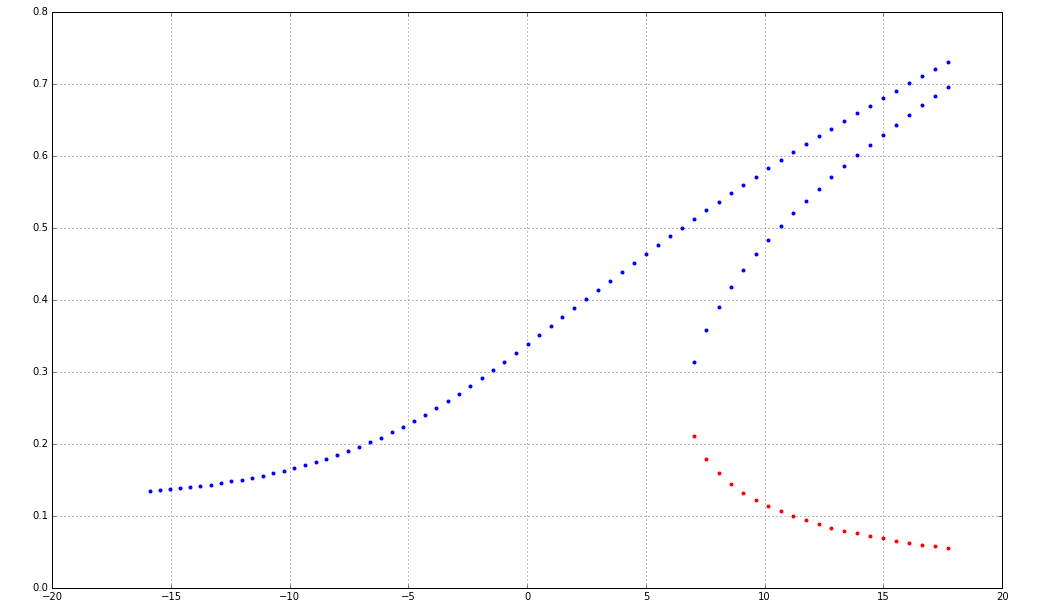

In [248]:

fig = create_fig()
plt.grid(b=True)

plt.plot(xs3[STABLE], ys3[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs3[UNSTABLE], ys3[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(xs3[UNKNOWN], ys3[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)

# Stability 4

In [12]:
STABLE = 0
UNSTABLE = 1
UNKNOWN = 2

def stability4(a0, b0):
    
    treshhold = 0.001
    
    # a b equation
    def ab(t, v):
        """
        F[0] = a
        f[1] = b
        """
        a = v[0]
        b = v[1]
        F = zeros(2)
        F[0] = -a * h2/2.0/mu + D/p0 * cos(b)
        F[1] = 1/p0 * (0.5 * delta + k_a*a**2 - D/a * sin(b))
        return F

    
    def check_ab_stability(_a, _b):
        ab_check1 = EquationCalculator(ab, [_a * 1.01, _b * 1.01], method='rk5a', ignore_cache=True, t_end=100.0, pb=False, tolerance=1e-4, step_size=1e-2)
        ab_check1.caclulate()
            
        diff = (ab_check1.v[0][-1] - _a) ** 2 + (ab_check1.v[1][-1] - _b) ** 2
        
        if diff < treshhold:
            return STABLE
        else:
            return UNSTABLE

            
    b0s = [b0, -b0]#, b0+pi, b0+2*pi, b0-pi, b0-2*pi]
    
    if any([check_ab_stability(a0, bi) == STABLE for bi in b0s]):
        return STABLE
    else:
        return UNSTABLE


In [188]:
#preparation

xs4, ys4 = [[], [], []], [[], [], []]
max_y = 0
# qis = np_concat(
#     (arange(0.5, 1.0, 0.01), arange(7.9, 8.1, 0.001))
# )
# qis = arange(0.5, 1.0, 0.01)

# calculate stability

pb = ProgressBar("Stability points", 0, len(qis) - 1)
pb_counter = 0
for qi in qis:
    pb.setValue(pb_counter)
    pb_counter += 1

    q = qi
    recalculate_stab_params()
    
    
    def f(n):
        return ((k_a*D12)**2 * (n**3)
                + delta*k_a*D12 * (n**2)
                + (0.25*delta**2 + a0**2) * n
                - a0**2)

    ns = roots(f, 0.0, 1.0, eps=1e-3)

    for n in ns:
        b = acos(n ** 0.5)
        a = (n ** 0.5) * (D / a0)
        st = stability4(a, b)

        ys4[st].append(a)
        xs4[st].append(-delta)
        
        if st == STABLE:
            ys4[UNKNOWN].append(q)
        else:
            xs4[UNKNOWN].append(q)
        
        if max_y < a:
            max_y = a    


[= Stability points ==============================]
[=================================================]


<IPython.core.display.Javascript object>


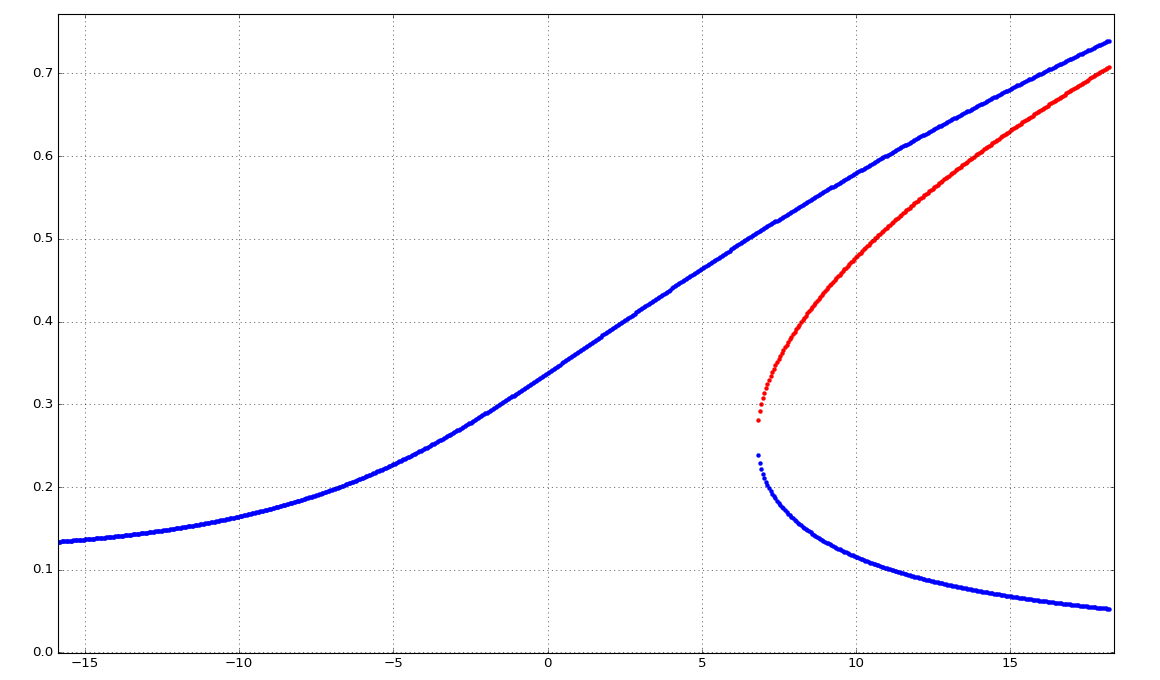

In [189]:

fig = create_fig()
plt.grid(b=True)

plt.plot(xs4[STABLE], ys4[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs4[UNSTABLE], ys4[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
# plt.plot(xs4[UNKNOWN], ys4[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)


In [306]:
for i in range(25):
    _a = ys4[UNSTABLE][i]
    q = xs4[UNKNOWN][i]
    recalculate_stab_params()
    _b = acos(_a * a0 / D) 
    print("q: %f, a:%f, b:%f" % (q,_a,_b))


q: 2.297573, a:0.155776, b:1.500851
q: 2.307573, a:0.158947, b:1.498080
q: 2.317573, a:0.162379, b:1.495118
q: 2.327573, a:0.166091, b:1.491950
q: 2.337573, a:0.170104, b:1.488557
q: 2.347573, a:0.174439, b:1.484919
q: 2.357573, a:0.179120, b:1.481014
q: 2.367573, a:0.184169, b:1.476820
q: 2.377573, a:0.189610, b:1.472312
q: 2.387573, a:0.195468, b:1.467466
q: 2.397573, a:0.201764, b:1.462255
q: 2.407573, a:0.208519, b:1.456654
q: 2.417573, a:0.215752, b:1.450636
q: 2.427573, a:0.223475, b:1.444177
q: 2.437573, a:0.231698, b:1.437254
q: 2.447573, a:0.240423, b:1.429849
q: 2.457573, a:0.249644, b:1.421945
q: 2.467573, a:0.259349, b:1.413530
q: 2.477573, a:0.269517, b:1.404597
q: 2.487573, a:0.280119, b:1.395145
q: 2.497573, a:0.291120, b:1.385176
q: 2.507573, a:0.302480, b:1.374699
q: 2.517573, a:0.314154, b:1.363723
q: 2.527573, a:0.326096, b:1.352262
q: 2.547573, a:0.350600, b:1.327946



[= Runge Kutta 5 Adaptive ========================]
[=================================================]


<IPython.core.display.Javascript object>


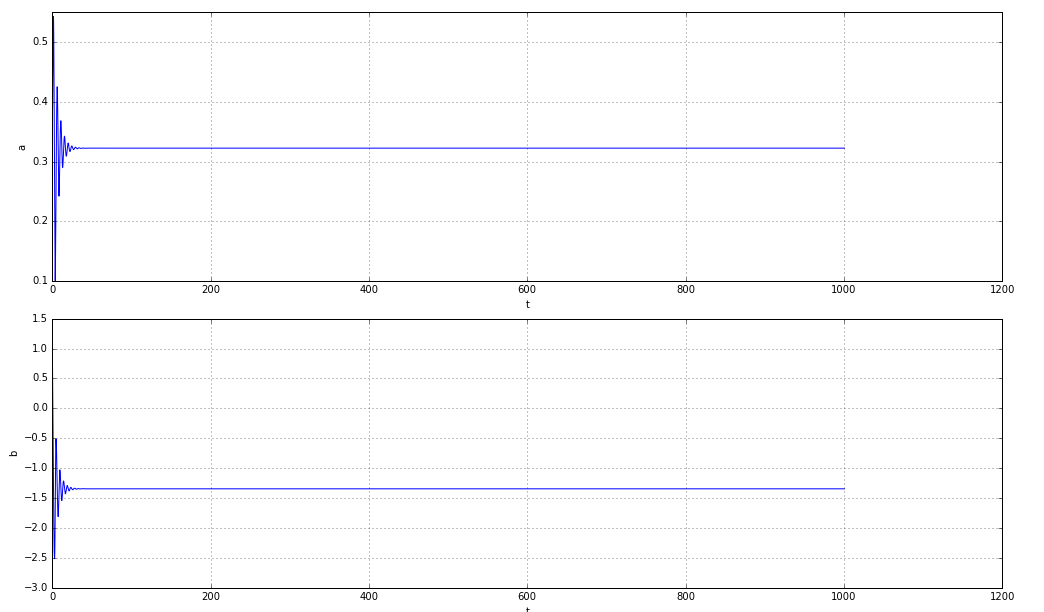

In [312]:
def check_ab_stability2(_q, _a, _b):
    global q
    q = _q
    recalculate_stab_params()
    
    def ab(t, v):
        """
        F[0] = a
        f[1] = b
        """
        a = v[0]
        b = v[1]
        F = zeros(2)
        F[0] = -a * h2/2.0/mu + D/p0 * cos(b)
        F[1] = 1/p0 * (0.5 * delta - k_a*a**2 - D/a * sin(b))
        return F
    
    ab_check1 = EquationCalculator(ab, [_a, _b], method='rk5a', ignore_cache=True, t_end=1000.0)
    ab_check1.caclulate()

    fig = create_fig()
    plots = add_subplots(fig, 2)
    ab_check1.plot(plots[0], "t", ".t", "a", ".v0", "b-")
    ab_check1.plot(plots[1], "t", ".t", "b", ".v1", "b-")

check_ab_stability2(2.547573, 0.350600, 1.327946)

In [16]:
# calculate field (optional)
field_y = arange(0.01, max_y + 0.01, 0.01)
pb = ProgressBar("Stability field", 0, len(qis) - 1)
pb_counter = 0

xs42 = deepcopy(xs4)
ys42 = deepcopy(ys4)

for qi in qis:
    pb.setValue(pb_counter)
    pb_counter += 1
    
    q = qi + 0.005
    recalculate_stab_params()
    
    for j in field_y:
        if j > max_y:
            continue

        a = j
        b = acos(a / D * a0)
        st = stability4(a, b)
        xs42[st].append(-delta)
        ys42[st].append(a)


[= Stability field ===============================]
[=================================================]


<IPython.core.display.Javascript object>


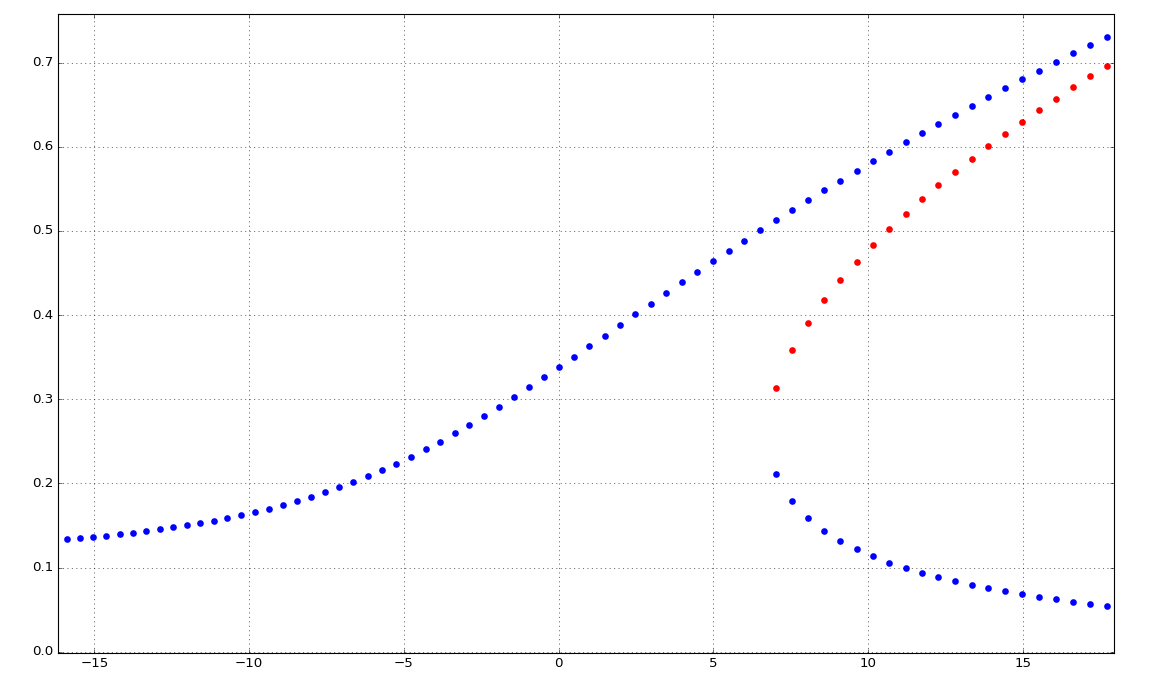

In [186]:

fig = create_fig()
plt.grid(b=True)

# plt.plot(xs42[STABLE], ys42[STABLE], "bo", markeredgewidth=0.0, markersize=4)
# plt.plot(xs42[UNSTABLE], ys42[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(xs4[STABLE], ys4[STABLE], "bo", markeredgewidth=0.0, markersize=6)
plt.plot(xs4[UNSTABLE], ys4[UNSTABLE], "ro", markeredgewidth=0.0, markersize=6)
# plt.plot(xs42[UNKNOWN], ys42[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)

In [30]:
count = 0
err = 0
max_err = -1

for b0 in arange(0, 100, 0.1):
    for b1 in arange(-0.01, 0.01, 0.001):
        lp = cos(b0 + b1)
        rp = cos(b0) - b1 * sin(b0)
        current_err = abs(lp - rp)
        err += current_err
        count += 1
        if current_err > max_err: max_err = current_err
        
print(err / count)
print(max_err)

1.06365152386e-05
4.99998005038e-05


## Stability 5

In [10]:
STABLE = 0
UNSTABLE = 1
UNKNOWN = 2

unknown_barier = 0.00001

def stability5(a0, b0):
    def try_stabl(a0, b0):
        m00 = -h2/mu/2.0
        m01 = -a0/p0 * (delta / 2.0 + k_a*(a0**2))
        m10 = 1/a0/p0 * (delta / 2.0 + 3*k_a*(a0**2))
        m11 = -h2/mu/2.0
        matrix = array([[m00, m01], [m10, m11]])

        w, v = eigenvalues(matrix)
        if all([abs(real(l)) < unknown_barier for l in w]):
            return UNKNOWN
        if all([real(l) < 0 for l in w]):
            return STABLE
        else:
            return UNSTABLE
        
#     bxs = [(b0 + pi*x) for x in [0]]
#     results = [try_stabl(-a0, bx) for bx in bxs]

    results = [try_stabl(a0, b0)]
    
    if any([st == STABLE for st in results]):
        return STABLE
    elif any([st == UNKNOWN for st in results]):
        return UNKNOWN
    else:
        return UNSTABLE
    

In [11]:
#preparation

xs5, ys5 = [[], [], []], [[], [], []]
max_y = 0

def f2(a):
    return (a**3 * k_a**2
            + a**2 * delta*k_a
            + a * ((p0*h2/mu)**2 + delta**2) / 4.0
            - D ** 2)
            

# calculate stability

pb = ProgressBar("Stability points", 0, len(qis) - 1)
pb_counter = 0
for qi in qis:
    pb.setValue(pb_counter)
    pb_counter += 1

    q = qi
    recalculate_stab_params()
    
    ns = roots(f2, 0.0, 2.0, eps=1e-3)

    for n in ns:            
        a = n ** 0.5
        b = acos(a * h2 * p0 / mu / 2.0 / D)
        st = stability5(a, b)

        ys5[st].append(a)
        xs5[st].append(delta)
        
        if max_y < a:
            max_y = a    


[= Stability points ==============================]
[=================================================]


In [38]:
# calculate field (optional)
field_y = arange(0.01, max_y + 0.1, 0.01)
# pb = ProgressBar("Stability field", 0, len(qis) - 1)
# pb_counter = 0

xs52 = deepcopy(xs5)
ys52 = deepcopy(ys5)

for qi in log_progress(qis, name="Field points"):
#     pb.setValue(pb_counter)
#     pb_counter += 1
    
    q = qi + 0.005
    recalculate_stab_params()
    
    for j in field_y:

        a = j
        try:
            b = acos(a / D * a0)
        except ValueError:
            continue
            
        st = stability5(a, b)
        xs52[st].append(delta)
        ys52[st].append(a)

<IPython.core.display.Javascript object>


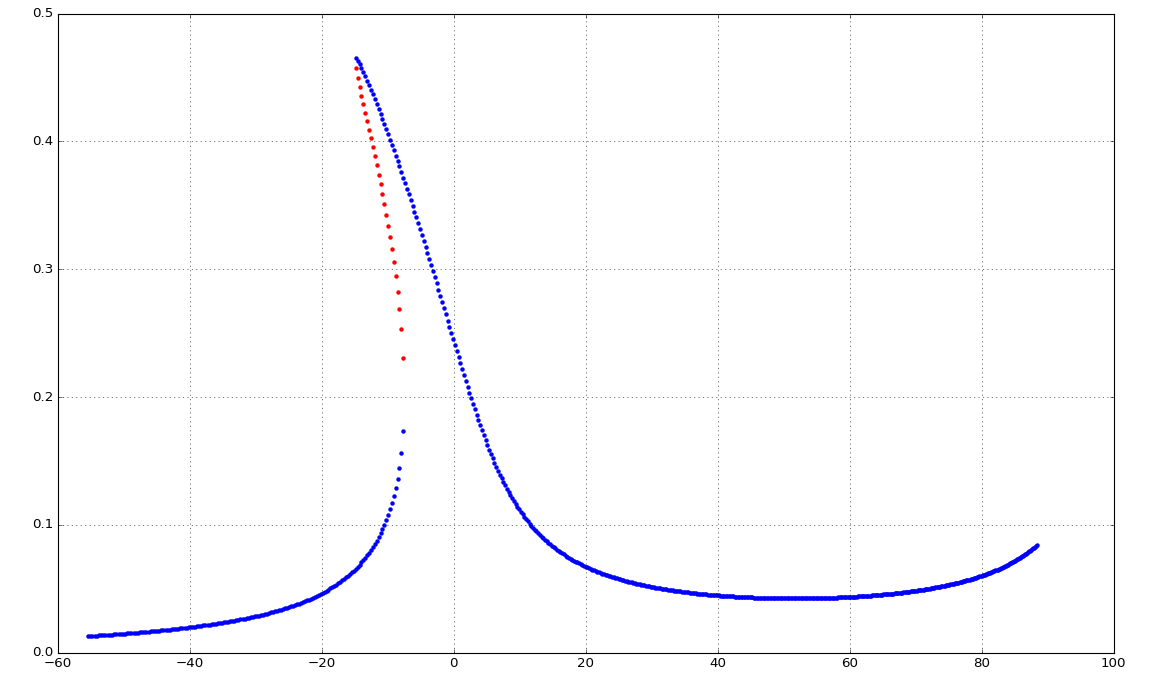

In [22]:


fig = create_fig()
plt.grid(b=True)

figsize(16, 6)

plt.plot(xs5[STABLE], ys5[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs5[UNSTABLE], ys5[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(xs5[UNKNOWN], ys5[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)

<IPython.core.display.Javascript object>


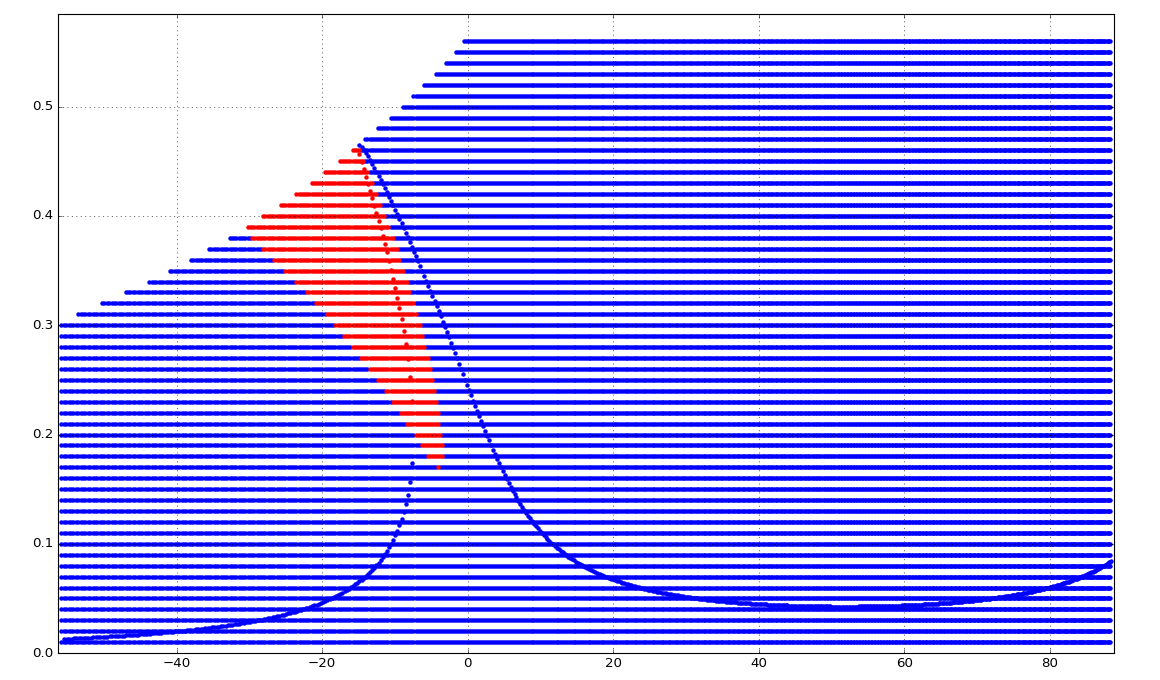

In [32]:

fig = create_fig()
plt.grid(b=True)

plt.plot(xs52[STABLE], ys52[STABLE], "bo", markeredgewidth=0.0, markersize=4)
plt.plot(xs52[UNSTABLE], ys52[UNSTABLE], "ro", markeredgewidth=0.0, markersize=4)
plt.plot(xs52[UNKNOWN], ys52[UNKNOWN], "go", markeredgewidth=0.0, markersize=4)

In [25]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )
